In [2]:
import pandas as pd

df = pd.read_csv('data/data_full.csv')
print(df.shape)
df.head(2)

(244, 12)


,R,G,B,day_of_year,time_of_day,weather_index,cloud_cover_percent,I_445,I_515,I_630,I_clear,date
0,0.0,0.0,0.0,212,13.326,1,96,844,1689,2127,13266,20250731
1,0.9,0.5,0.6,212,13.911,1,100,19888,35221,30901,65535,20250731


In [3]:
df['date'].value_counts()

date
20250729    110
20250731     56
20250801     52
20251028     26
Name: count, dtype: int64

## Split data

In [7]:
df_train = df[(df['date'] != 20250801) &
              (df['date'] != 20251028)]
print(df_train.shape)
df_train.head(2)

(166, 12)


,R,G,B,day_of_year,time_of_day,weather_index,cloud_cover_percent,I_445,I_515,I_630,I_clear,date
0,0.0,0.0,0.0,212,13.326,1,96,844,1689,2127,13266,20250731
1,0.9,0.5,0.6,212,13.911,1,100,19888,35221,30901,65535,20250731


In [8]:
df_test = df[~((df['date'] != 20250801) &
              (df['date'] != 20251028))]
print(df_test.shape)
df_test.head(2)

(78, 12)


,R,G,B,day_of_year,time_of_day,weather_index,cloud_cover_percent,I_445,I_515,I_630,I_clear,date
6,0.0,0.0,0.0,213,13.491,1,37,1019,1893,2197,16726,20250801
7,0.4,0.2,0.6,213,13.496,1,37,19354,15527,14892,50879,20250801


In [9]:
# Save split data

if True:
    df_train.to_csv('data_split/data_train.csv', index=False)
    df_test.to_csv('data_split/data_test.csv', index=False)

## Meta-learning

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [11]:
# Split tasks and 

X_cols = ['R', 'G', 'B', 'day_of_year', 'time_of_day', 'weather_index', 'cloud_cover_percent']
Y_cols = ['I_445', 'I_515', 'I_630', 'I_clear']

grouped_by_date = df_train.groupby('date')

tasks = []
for day, df_day in grouped_by_date:
    X_day = df_day[X_cols].to_numpy()
    Y_day = df_day[Y_cols].to_numpy()
    if len(X_day) < 10:
        continue
    tasks.append((day, X_day, Y_day))

print(f"Total days (tasks): {len(tasks)}")

Total days (tasks): 2


In [12]:
# Scale data

X_all = df_train[X_cols].to_numpy()
Y_all = df_train[Y_cols].to_numpy()

X_scaler = StandardScaler()
Y_scaler = StandardScaler()

X_all_scaled = X_scaler.fit_transform(X_all)
Y_all_scaled = Y_scaler.fit_transform(Y_all)

tasks_scaled = []
for day, _, _ in tasks:
    mask = df_train['date'] == day
    X_day = X_all_scaled[mask.to_numpy()]
    Y_day = Y_all_scaled[mask.to_numpy()]
    tasks_scaled.append((day, X_day, Y_day))

In [13]:
# Meta-learning config and loop

np.random.seed(0)
input_dim = len(X_cols)
output_dim = len(Y_cols)
k_shot = 10
meta_lr = 0.001
inner_lr = 0.005
meta_iters = 500

W_meta = np.random.randn(output_dim, input_dim) * 0.01
b_meta = np.zeros(output_dim)

for meta_iter in range(meta_iters):
    dW_meta = np.zeros_like(W_meta)
    db_meta = np.zeros_like(b_meta)
    
    for day, X_day, Y_day in tasks_scaled:
        n = len(X_day)
        if n < k_shot * 2:
            continue  # skip days with too few samples
        
        # Randomly sample train/val split within this day
        idx = np.random.permutation(n)
        idx_train = idx[:k_shot]
        idx_val = idx[k_shot:2*k_shot]
        
        X_train, Y_train = X_day[idx_train], Y_day[idx_train]
        X_val, Y_val = X_day[idx_val], Y_day[idx_val]
        
        # Inner adaptation
        Y_pred = X_train @ W_meta.T + b_meta
        grad_W = (2 / k_shot) * (Y_pred - Y_train).T @ X_train
        grad_b = (2 / k_shot) * np.sum(Y_pred - Y_train, axis=0)
        W_task = W_meta - inner_lr * grad_W
        b_task = b_meta - inner_lr * grad_b
        
        # Outer evaluation
        Y_val_pred = X_val @ W_task.T + b_task
        grad_W_meta = (2 / k_shot) * (Y_val_pred - Y_val).T @ X_val
        grad_b_meta = (2 / k_shot) * np.sum(Y_val_pred - Y_val, axis=0)
        
        dW_meta += grad_W_meta
        db_meta += grad_b_meta
    
    # Meta-update
    W_meta -= meta_lr * dW_meta / len(tasks_scaled)
    b_meta -= meta_lr * db_meta / len(tasks_scaled)
    
    if meta_iter % 50 == 0:
        loss_meta = np.mean((Y_val_pred - Y_val)**2)
        print(f"Iter {meta_iter:03d} | Meta-loss: {loss_meta:.6f}")

Iter 000 | Meta-loss: 1.016511
Iter 050 | Meta-loss: 1.175409
Iter 100 | Meta-loss: 0.724395
Iter 150 | Meta-loss: 0.422492
Iter 200 | Meta-loss: 0.310789
Iter 250 | Meta-loss: 0.288091
Iter 300 | Meta-loss: 0.282872
Iter 350 | Meta-loss: 0.196464
Iter 400 | Meta-loss: 0.229807
Iter 450 | Meta-loss: 0.127480


In [ ]:
print("W_meta: ", W_meta)
print("b_meta: ", b_meta)

## Predition

In [ ]:
np.random.seed(42)
k_shot = 10        
inner_lr = 0.05

test_days = sorted(df_test['date'].unique())

results = []

for day_target in test_days:
    df_target = df_test[df_test['date'] == day_target]
    if len(df_target) < 10:
        continue  # skip very small days

    X_target = df_target[X_cols].to_numpy()
    Y_target = df_target[Y_cols].to_numpy()
    X_target_scaled = X_scaler.transform(X_target)
    Y_target_scaled = Y_scaler.transform(Y_target)

    # Split into few-shot
    nT = len(X_target_scaled)
    # k = min(k_shot, nT // 2)
    k = 10
    idx = np.random.choice(nT, size=k, replace=False)
    mask = np.ones(nT, dtype=bool)
    mask[idx] = False
    X_adapt, Y_adapt = X_target_scaled[idx], Y_target_scaled[idx]
    X_eval,  Y_eval  = X_target_scaled[mask], Y_target_scaled[mask]

    # BEFORE ADAPTATION
    Y_pred_before_scaled = X_eval @ W_meta.T + b_meta
    Y_pred_before = Y_scaler.inverse_transform(Y_pred_before_scaled)
    Y_eval_orig   = Y_scaler.inverse_transform(Y_eval)

    r2_before = [r2_score(Y_eval_orig[:, i], Y_pred_before[:, i]) for i in range(len(Y_cols))]

    # AFTER ADAPTATION
    Y_pred_adapt = X_adapt @ W_meta.T + b_meta
    grad_W = (2 / len(X_adapt)) * (Y_pred_adapt - Y_adapt).T @ X_adapt
    grad_b = (2 / len(X_adapt)) * np.sum(Y_pred_adapt - Y_adapt, axis=0)
    W_adapt = W_meta - inner_lr * grad_W
    b_adapt = b_meta - inner_lr * grad_b

    Y_pred_after_scaled = X_eval @ W_adapt.T + b_adapt
    Y_pred_after = Y_scaler.inverse_transform(Y_pred_after_scaled)

    r2_after = [r2_score(Y_eval_orig[:, i], Y_pred_after[:, i]) for i in range(len(Y_cols))]

    results.append({
        'day': day_target,
        'r2_before': r2_before,
        'r2_after': r2_after,
    })

    print(f"\nDay {day_target} | samples={nT} | few-shot={k}")
    print("R2 before:", dict(zip(Y_cols, np.round(r2_before, 3))))
    print("R2 after :", dict(zip(Y_cols, np.round(r2_after, 3))))

# Average R2 across all test days per channel
r2_before_all = np.array([r['r2_before'] for r in results])
r2_after_all  = np.array([r['r2_after']  for r in results])

avg_r2_before = np.mean(r2_before_all, axis=0)
avg_r2_after  = np.mean(r2_after_all, axis=0)

print("\n=============================")
print("Average per-channel R2 before adaptation:")
print(dict(zip(Y_cols, np.round(avg_r2_before, 3))))
print("\nAverage per-channel R2 after adaptation:")
print(dict(zip(Y_cols, np.round(avg_r2_after, 3))))

Day 20250801 | samples=52 | few-shot=10
R2 before: {'I_445': 0.824, 'I_515': 0.773, 'I_630': 0.716, 'I_clear': 0.086}
R2 after : {'I_445': 0.866, 'I_515': 0.874, 'I_630': 0.812, 'I_clear': 0.697}
Day 20251028 | samples=26 | few-shot=10
R2 before: {'I_445': -212.146, 'I_515': -278.795, 'I_630': -367.93, 'I_clear': -2323.905}
R2 after : {'I_445': -179818226.269, 'I_515': -235985591.429, 'I_630': -312633645.406, 'I_clear': -1953234877.565}

Average per-channel R2 before adaptation:
{'I_445': -105.661, 'I_515': -139.011, 'I_630': -183.607, 'I_clear': -1161.91}

Average per-channel R2 after adaptation:
{'I_445': -89909112.702, 'I_515': -117992795.278, 'I_630': -156316822.297, 'I_clear': -976617438.434}


In [ ]:
print("Latest adapt: ")
print("W_adapt: ", W_adapt)
print("b_adapt: ", b_adapt)

W_meta:  [[-0.01727829  0.01357206  0.61136076  0.17424041  0.05535115 -0.05256341
  -0.01322251]
 [ 0.00756919  0.60760504  0.01438849  0.17478587  0.03569596 -0.04851973
  -0.00532481]
 [ 0.51837755  0.03940016  0.00249201  0.16443779 -0.15648455 -0.11325757
  -0.06984775]
 [ 0.13385861  0.33982573  0.21116225  0.30680038 -0.02077189 -0.12920447
  -0.09180634]]
b_meta:  [0.02671844 0.02445574 0.02161306 0.04452738]

W_adapt:  [[-1.31124403e+00  8.80015154e-02 -1.64868318e-02 -1.59110315e+02
   1.72494365e+00  4.78613402e+00  2.15515232e+00]
 [-1.29160620e+00  6.94196573e-01 -6.68681811e-01 -1.61310789e+02
   1.72977246e+00  4.85703959e+00  2.19287197e+00]
 [-6.97826448e-01  1.04792662e-01 -6.72035972e-01 -1.54363202e+02
   1.46387869e+00  4.58093573e+00  2.03371245e+00]
 [-2.15593756e+00  4.85353187e-01 -9.75385990e-01 -2.84770603e+02
   2.96896431e+00  8.53078953e+00  3.78885475e+00]]
b_adapt:  [-1.64082253 -1.66612757 -1.59612804 -2.93993177]


## Vis results

In [16]:
Y_eval_orig

array([[18729., 14381., 16374., 44478.],
       [24921., 14313., 19206., 52824.],
       [ 3789., 26574.,  7338., 33901.],
       [16112., 65340., 17163., 65535.],
       [  730., 27069., 27667., 47611.],
       [21708., 14213., 16266., 46780.],
       [25003., 33493., 28437., 65535.],
       [25002., 33030., 10790., 60131.],
       [19249., 65511., 32095., 65535.],
       [30910.,  8148., 25044., 57764.],
       [24879.,  1626., 25423., 48858.],
       [27965., 26879.,  8512., 57282.],
       [ 3788., 13932., 13620., 30249.],
       [ 4034., 46029., 28816., 65535.],
       [ 3941., 39171., 11274., 48319.],
       [21750.,  8281., 16832., 44740.]])

In [21]:
Y_pred_after

array([[-1.32924664e+08, -2.85928221e+08, -1.35093663e+08,
        -4.73892169e+08],
       [-1.32928607e+08, -2.85945050e+08, -1.35100171e+08,
        -4.73916802e+08],
       [-1.32912312e+08, -2.85873045e+08, -1.35075620e+08,
        -4.73818255e+08],
       [-1.32922430e+08, -2.85887711e+08, -1.35088766e+08,
        -4.73862378e+08],
       [-1.32939158e+08, -2.85924850e+08, -1.35088418e+08,
        -4.73900308e+08],
       [-1.32924649e+08, -2.85932482e+08, -1.35095789e+08,
        -4.73897970e+08],
       [-1.32939246e+08, -2.85955451e+08, -1.35105513e+08,
        -4.73945404e+08],
       [-1.32916146e+08, -2.85907175e+08, -1.35092630e+08,
        -4.73869746e+08],
       [-1.32941623e+08, -2.85932113e+08, -1.35101590e+08,
        -4.73931084e+08],
       [-1.32936533e+08, -2.85974143e+08, -1.35109041e+08,
        -4.73956539e+08],
       [-1.32936678e+08, -2.85969797e+08, -1.35104988e+08,
        -4.73947363e+08],
       [-1.32912559e+08, -2.85907916e+08, -1.35092952e+08,
      

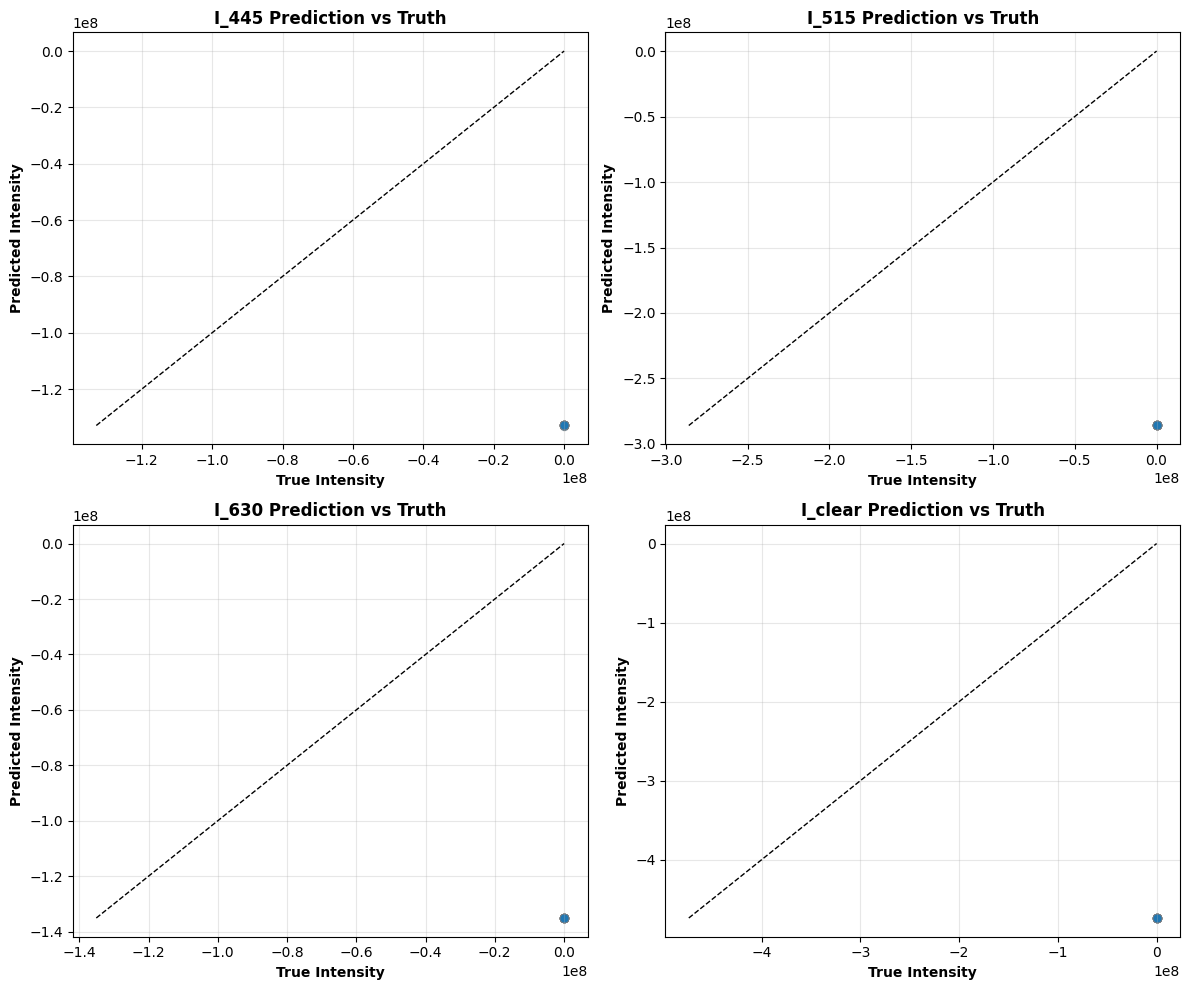

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

true_cols = ['I_445', 'I_515', 'I_630', 'I_clear']

# Ensure arrays are numpy arrays
Y_eval_orig = np.array(Y_eval_orig)
Y_pred_after = np.array(Y_pred_after)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(true_cols):
    ax = axes[i]
    ax.scatter(
        Y_eval_orig[:, i],
        Y_pred_after[:, i],
        alpha=0.6,
        edgecolor='gray',
        linewidth=0.5,
        s=40
    )

    # Parity line
    min_val = min(Y_eval_orig[:, i].min(), Y_pred_after[:, i].min())
    max_val = max(Y_eval_orig[:, i].max(), Y_pred_after[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

    # Labels and titles
    ax.set_title(f"{col} Prediction vs Truth", fontsize=12, fontweight='bold')
    ax.set_xlabel("True Intensity", fontsize=10, fontweight='bold')
    ax.set_ylabel("Predicted Intensity", fontsize=10, fontweight='bold')

    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
